In [4]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import nilearn
from nilearn import image
from nilearn import plotting

In [6]:
path = '/home/annabelle/Documents/brainhack/harveyaa_fMRI_neuroticism/100307/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR.nii'

In [23]:
img = image.load_img(path)
data = image.get_data(path)
print(data.shape)

(91, 109, 91, 1200)


In [20]:
first_volume = image.index_img(path, 0)

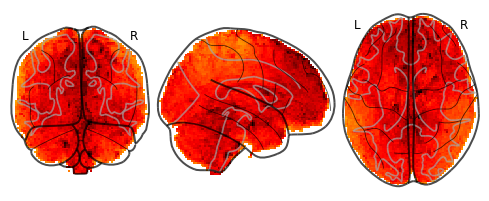

In [21]:
plotting.plot_glass_brain(first_volume, threshold='auto')